In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load MIRIAD Dataset

cuda
torch.Size([2, 1, 37, 77, 77])


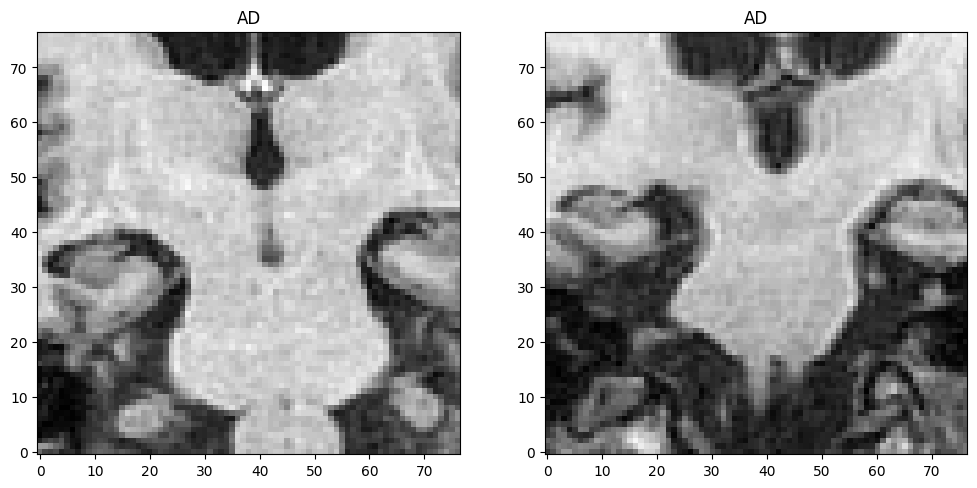

In [9]:
import torchvision.transforms as transforms
from miriad import MiriadDataset
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

batch_size=2

train_dataset = MiriadDataset(root="data/miriad", train=True, transform=transform, crop=0.7)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataset = MiriadDataset(root="data/miriad", train=False, transform=transform, crop=0.7)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('HC', 'AD')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
mris, labels = next(dataiter)

print(mris.size())

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(mris, labels):
    mri_sample_slice = sample_data[0, 16, :, :]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(mri_sample_slice.T, cmap='gray', origin='lower')
    plt.title(f"{classes[sample_label]}")  # Display the label as the title
    i += 1
plt.show()

### 2. 3D-CNN Classification Model

In [5]:
from models import AlzheimersClassification3DCNN

model = AlzheimersClassification3DCNN().double().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameter count = {total_params}")

AlzheimersClassification3DCNN(
  (_conv_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): ReLU()
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): ReLU()
    (10): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AdaptiveAvgPool3d(output_size=(4, 4, 4))
  )
  (_fc1): Linear(in_features=1024, out_features=256, bias=True)
  (_dropout): Dropout(p=0.2, inplace=False)
  (_fc2): Linear(in

In [6]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9, weight_decay=0.001)
epochs = 25

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 3. Swin-Transformer Classification Model (scratch)

In [7]:
from models import SvinViTAlzheimersClassifier

device = "cuda"

swin_model = SvinViTAlzheimersClassifier().double().to(device)
print(swin_model)
total_params = sum(p.numel() for p in swin_model.parameters())
print(f"Parameter count = {total_params}")

SvinViTAlzheimersClassifier(
  (_svin_vit): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2

In [4]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.cuda.empty_cache()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(swin_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 25

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(swin_model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(swin_model, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.793, training acc: 52.500
Validation loss: 0.766, validation acc: 58.750
[INFO]: Epoch 2 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.738, training acc: 48.125
Validation loss: 0.775, validation acc: 41.250
[INFO]: Epoch 3 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.713, training acc: 50.000
Validation loss: 0.686, validation acc: 58.750
[INFO]: Epoch 4 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.712, training acc: 50.625
Validation loss: 0.746, validation acc: 41.250
[INFO]: Epoch 5 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.714, training acc: 48.125
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 6 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.694, training acc: 53.125
Validation loss: 0.819, validation acc: 58.750
[INFO]: Epoch 7 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.726, training acc: 51.250
Validation loss: 0.794, validation acc: 41.250
[INFO]: Epoch 8 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 9 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.000
Validation loss: 0.684, validation acc: 41.250
[INFO]: Epoch 10 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.706, training acc: 49.375
Validation loss: 0.682, validation acc: 58.750
[INFO]: Epoch 11 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.714, training acc: 48.125
Validation loss: 0.705, validation acc: 41.250
[INFO]: Epoch 12 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.625
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 13 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 54.375
Validation loss: 0.763, validation acc: 41.250
[INFO]: Epoch 14 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.703, training acc: 50.000
Validation loss: 0.680, validation acc: 41.250
[INFO]: Epoch 15 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.696, training acc: 50.000
Validation loss: 0.681, validation acc: 41.250
[INFO]: Epoch 16 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 50.000
Validation loss: 0.687, validation acc: 41.250
[INFO]: Epoch 17 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.710, training acc: 50.000
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 18 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 52.500
Validation loss: 0.713, validation acc: 41.250
[INFO]: Epoch 19 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.000
Validation loss: 0.710, validation acc: 41.250
[INFO]: Epoch 20 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.721, validation acc: 41.250
[INFO]: Epoch 21 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.000
Validation loss: 0.688, validation acc: 41.250
[INFO]: Epoch 22 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 50.000
Validation loss: 0.680, validation acc: 41.250
[INFO]: Epoch 23 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.000
Validation loss: 0.688, validation acc: 41.250
[INFO]: Epoch 24 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.697, validation acc: 41.250
[INFO]: Epoch 25 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.698, training acc: 50.000
Validation loss: 0.698, validation acc: 41.250


### 4. Swin-Transformer Classification Small Model (scratch)

In [4]:
from models import SvinViTAlzheimersClassifierSmall

device = "cuda"

swin_model_small = SvinViTAlzheimersClassifierSmall().double().to(device)
print(swin_model_small)
total_params = sum(p.numel() for p in swin_model_small.parameters())
print(f"Parameter count = {total_params}")

SvinViTAlzheimersClassifierSmall(
  (_svin_vit): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=8, out_features=24, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=8, out_features=8, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=8, out_features=16, bias=True)
              (linear2): L

In [5]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.cuda.empty_cache()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(swin_model_small.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 30

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(swin_model_small, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(swin_model_small, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [1, 36, 77, 77] at entry 0 and [1, 37, 77, 77] at entry 1


### 5. Swin-Transformer Classification Large Model (pretrained)

In [10]:
from models import SwinVitPretrainedClassifier

device = "cuda"

pretrained_swin_weights_path = "pretrained/fold4_f48_ep300_4gpu_dice0_9035/model.pt"
pretrained_weights = torch.load(pretrained_swin_weights_path)

state_dict_mod = {}
for key, value in pretrained_weights["state_dict"].items():
    # some modification to be able to load the params correctly
    parts = key.split('.')
    parts[0] = 'module'
    new_key = '.'.join(parts)
    new_key = new_key.replace("linear", "fc" )
    state_dict_mod[new_key] = value

pretrained_weights["state_dict"] = state_dict_mod

swin_pretrained_model = SwinVitPretrainedClassifier().double().to(device)
swin_pretrained_model.load_from(pretrained_weights)
print(swin_pretrained_model)

SwinVitPretrainedClassifier(
  (_conv): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(4, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_f

In [11]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.cuda.empty_cache()

# training 
import torch.optim as optim
import torch.nn as nn

torch.cuda.empty_cache() 

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(swin_pretrained_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 10

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(swin_pretrained_model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(swin_pretrained_model, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.625
Validation loss: 0.693, validation acc: 52.500
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.703, training acc: 50.625
Validation loss: 0.712, validation acc: 52.500
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.704, training acc: 48.750
Validation loss: 0.692, validation acc: 52.500
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.701, training acc: 50.625
Validation loss: 0.707, validation acc: 52.500
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.625
Validation loss: 0.718, validation acc: 52.500
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.695, training acc: 49.375
Validation loss: 0.694, validation acc: 52.500
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.625
Validation loss: 0.696, validation acc: 52.500
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.625
Validation loss: 0.692, validation acc: 52.500
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.708, training acc: 50.625
Validation loss: 0.692, validation acc: 52.500
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.689, training acc: 51.250
Validation loss: 0.750, validation acc: 47.500
